# **Final Project Sistem Terinspirasi Makhluk Hidup**


**Topik**: Penerapan Genetic Algorithms untuk Seleksi Fitur pada Pemodelan Support Vector Machine (Studi Kasus: Faktor Risiko Diabetes)


**Nama Kelompok 2**:
- Alifya Aisyah Ariyanto 23/528743/PPA/06685
- Alvendra Mahardika 24/547263/PPA/06876
- Ismi Nurul Na’imah 24/541118/PPA/06824
- Widya Amelia Putri 24/547828/PPA/06910


**Dosen**	:	Aina Musdholifah, S.Kom., M.Kom. Ph.D

---

## Pemodelan SVM Tanpa GA

In [93]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import pandas as pd

# Load the dataset
diabetes_data = pd.read_csv('diabetes_risk_data.csv')

# Separate features and target
X = diabetes_data.drop(columns=['class_Positive'])
y = diabetes_data['class_Positive']

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

# Transform ke data frame
X_train_scale_df = pd.DataFrame(X_train_scale, columns=X.columns)
X_test_scale_df = pd.DataFrame(X_test_scale, columns=X.columns)
y_train_df = pd.DataFrame(y_train)
y_test_df = pd.DataFrame(y_test)

# Define the parameter grid for each kernel
param_grid = {
    'linear': {'C': [0.1, 1, 10, 100]},
    'rbf': {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001]},
    'sigmoid': {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001]},
    'poly': {'C': [0.1, 1, 10, 100], 'degree': [2, 3, 4], 'gamma': ['scale', 'auto']}
}

# Function to perform grid search for a specific kernel
def perform_grid_search(kernel, param_grid):
    svc = SVC(kernel=kernel)
    grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train_scale, y_train)

    # Predict and calculate accuracy
    y_pred = grid_search.best_estimator_.predict(X_test_scale)
    accuracy = accuracy_score(y_test, y_pred)

    return grid_search.best_params_, accuracy

# Evaluate each kernel
results = {}
for kernel, params in param_grid.items():
    best_params, accuracy = perform_grid_search(kernel, params)
    results[kernel] = {'Best Params': best_params, 'Accuracy': accuracy}

# Convert results dictionary to a DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df.reset_index(inplace=True)
results_df.rename(columns={'index': 'Kernel'}, inplace=True)

# Display the DataFrame
print(results_df)


    Kernel                               Best Params  Accuracy
0   linear                                 {'C': 10}  0.932692
1      rbf                   {'C': 10, 'gamma': 0.1}  0.980769
2  sigmoid                  {'C': 10, 'gamma': 0.01}  0.913462
3     poly  {'C': 10, 'degree': 3, 'gamma': 'scale'}  0.961538


## Implementasi GA

In [ ]:
import numpy as np
import random

class GeneticAlgorithm:
    def __init__(self, X, y, kernel_params, pop_size, p_cross, p_mut, mating_pool_size):
        self.X = X
        self.y = y
        self.n_features = X.shape[1]
        self.kernel_params = kernel_params
        self.pop_size = pop_size
        self.p_cross = p_cross
        self.p_mut = p_mut
        self.mating_pool_size = mating_pool_size
        self.epsilon = 1e-4
        self.population = self.initialize_population()
        self.best_fitness = 0
        self.prev_best_fitness = 0
        self.fitness_history = []
        self.no_improvement_counter = 0

    def initialize_population(self):
        population = []
        for _ in range(self.pop_size):
            chromosome = np.zeros(self.n_features)
            n_selected = max(3, np.random.randint(3, self.n_features // 2))
            selected_features = np.random.choice(self.n_features, n_selected, replace=False)
            chromosome[selected_features] = 1
            population.append(chromosome)
        return np.array(population)

    def fitness_function(self, chromosome, X_train_scale_df=X_train_scale_df, X_test_scale_df=X_test_scale_df):
        selected_features = self.X[:, chromosome == 1]

        if selected_features.shape[1] < 3:
            return 0

        selected_feature_indices = np.where(chromosome == 1)[0]
        X_train_scaled = X_train_scale_df.iloc[:,selected_feature_indices]
        X_test_scaled = X_test_scale_df.iloc[:,selected_feature_indices]
        X_train_scaled = X_train_scaled.values
        X_test_scaled = X_test_scaled.values

        svm = SVC(**self.kernel_params)
        svm.fit(X_train_scaled, y_train)

        y_pred = svm.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)

        return accuracy

    def tournament_selection(self, tournament_size=4):
        tournament_idx = np.random.choice(self.pop_size, tournament_size)
        tournament = self.population[tournament_idx]
        fitness_values = [self.fitness_function(individual, X_train_scale_df, X_test_scale_df) for individual in tournament]
        return tournament[np.argmax(fitness_values)]

    def two_point_crossover(self, parent1, parent2):
        if len(parent1) < 4:
            return parent1, parent2

        point1, point2 = sorted(np.random.choice(len(parent1)-1, 2, replace=False))
        point2 += 1

        child1 = np.copy(parent1)
        child2 = np.copy(parent2)

        child1[point1:point2] = parent2[point1:point2]
        child2[point1:point2] = parent1[point1:point2]

        return child1, child2

    def bit_flip_mutation(self, individual):
        mutated = np.copy(individual)
        for i in range(len(mutated)):
            if np.random.random() < self.p_mut:
                mutated[i] = 1 - mutated[i]

        if sum(mutated) < 3:
            n_needed = 3 - sum(mutated)
            zero_indices = np.where(mutated == 0)[0]
            if len(zero_indices) >= n_needed:
                to_flip = np.random.choice(zero_indices, int(n_needed), replace=False)
                mutated[to_flip] = 1

        return mutated

    def evolve(self):
        fitness_values = [self.fitness_function(ind, X_train_scale_df, X_test_scale_df) for ind in self.population]
        current_best_fitness = max(fitness_values)

        # Update fitness history
        self.fitness_history.append(current_best_fitness)

        # Create mating pool
        mating_pool = [self.tournament_selection() for _ in range(self.mating_pool_size)]

        # Perform crossover and mutation
        offspring = []
        for i in range(0, len(mating_pool)-1, 2):
            if np.random.random() < self.p_cross:
                child1, child2 = self.two_point_crossover(mating_pool[i], mating_pool[i+1])
                offspring.extend([
                    self.bit_flip_mutation(child1),
                    self.bit_flip_mutation(child2)
                ])
            else:
                offspring.extend([mating_pool[i], mating_pool[i+1]])

        # Replace worst individuals (steady-state update)
        fitness_values = [self.fitness_function(ind, X_train_scale_df, X_test_scale_df) for ind in self.population]
        sorted_indices = np.argsort(fitness_values)

        for i, child in enumerate(offspring):
            if i < len(sorted_indices):
                self.population[sorted_indices[i]] = child

        # Check convergence with epsilon
        if abs(current_best_fitness - self.best_fitness) < self.epsilon:
          self.no_improvement_counter += 1
        else:
          self.no_improvement_counter = 0
          self.best_fitness = current_best_fitness

        # Return whether converged
        return self.no_improvement_counter >= 5

    def run(self, max_generations=100):
        generation = 0
        converged = False

        while not converged and generation < max_generations:
            converged = self.evolve()
            generation += 1

        # Get best solution
        fitness_values = [self.fitness_function(ind) for ind in self.population]
        best_idx = np.argmax(fitness_values)
        best_chromosome = self.population[best_idx]
        best_fitness = fitness_values[best_idx]

        print(f"Generation {generation}, Best Fitness: {self.best_fitness:.6f}")
        return best_chromosome, best_fitness, generation

def run_experiment(X, y, kernel_name, kernel_params, pop_sizes, p_cross_values, feature_names):
    results = []

    # Variables to track best results for this kernel
    best_accuracy = 0
    best_config = None
    best_features = None

    for pop_size in pop_sizes:
        p_mut_value = np.arange(1/(16 * pop_size), 0.0625, 0.025)
        for p_mut in p_mut_value:
            mating_pool_size = pop_size // 2
            for p_cross in p_cross_values:
                print(f"\nRunning with pop_size={pop_size}, p_cross={p_cross}, p_mut={p_mut}")

                ga = GeneticAlgorithm(
                    X=X,
                    y=y,
                    kernel_params=kernel_params,
                    pop_size=pop_size,
                    p_cross=p_cross,
                    p_mut=p_mut,
                    mating_pool_size=mating_pool_size
                )

                best_solution, best_fitness, generations = ga.run()

                # Get selected feature names
                selected_feature_indices = np.where(best_solution == 1)[0]
                selected_feature_names = feature_names[selected_feature_indices]


                current_result = {
                    'kernel': kernel_name,
                    'pop_size': pop_size,
                    'p_cross': p_cross,
                    'p_mut': p_mut,
                    'accuracy': best_fitness,
                    'generations': generations,
                    'selected_features': sum(best_solution),
                    'feature_names': selected_feature_names  # Store feature names
                }

                results.append(current_result)

                # Update best configuration if current result is better
                if best_fitness > best_accuracy:
                    best_accuracy = best_fitness
                    best_config = current_result
                    best_features = selected_feature_names

    # Print best configuration for this kernel
    print(f"\n{'='*50}")
    print(f"Best Results for {kernel_name.upper()} kernel:")
    print(f"{'='*50}")
    print(f"Best Accuracy: {best_config['accuracy']:.4f}")
    print(f"Number of Generations: {best_config['generations']}")
    print(f"Number of Selected Features: {best_config['selected_features']}")
    print(f"Selected Features: {best_config['selected_features']}")
    print(f"Best Configuration:")
    print(f"- Population Size: {best_config['pop_size']}")
    print(f"- Crossover Probability: {best_config['p_cross']}")
    print(f"- Mutation Probability: {best_config['p_mut']:.6f}")
    print(f"{'='*50}\n")

    return results, best_accuracy, best_config

# Main Experiment Execution
diabetes_data = pd.read_csv('diabetes_risk_data.csv')
X = diabetes_data.drop(columns=['class_Positive']).values
feature_names = np.array(diabetes_data.drop(columns=['class_Positive']).columns)
y = diabetes_data['class_Positive'].values

pop_sizes = [20, 30, 40, 50]
p_cross_values = [0.6, 0.7, 0.8, 0.9]

kernel_configs = {
    'linear': {'kernel': 'linear', 'C': 10},
    'rbf': {'kernel': 'rbf', 'C': 10, 'gamma': 0.1},
    'sigmoid': {'kernel': 'sigmoid', 'C': 10, 'gamma': 0.01},
    'poly': {'kernel': 'poly', 'C': 10, 'degree': 3, 'gamma': 'scale'}
}

num_experiments = 2
experiment_results = []

for experiment in range(num_experiments):
    print(f"\n{'='*20} Starting Experiment {experiment + 1} {'='*20}")
    experiment_data = []
    best_accuracy_per_kernel = {}

    for kernel_name, params in kernel_configs.items():
        print(f"\nRunning experiments for {kernel_name} kernel...")
        results, best_accuracy, best_config = run_experiment(
            X, y, kernel_name, params,
            pop_sizes, p_cross_values, feature_names
        )
        experiment_data.extend(results)
        best_accuracy_per_kernel[kernel_name] = best_accuracy
        experiment_results.append((experiment + 1, kernel_name, results, best_config))

    # Detailed output for each kernel in the current experiment
    print(f"\n{'='*50}")
    print(f"Results for Experiment {experiment + 1}")
    print(f"{'='*50}")

    for kernel in kernel_configs.keys():
        print(f"\nResults for Kernel: {kernel.upper()}")
        kernel_df = pd.DataFrame([res for res in experiment_data if res['kernel'] == kernel])
        print(kernel_df.to_string(index=False))  # Pretty-print the DataFrame for readability

    # Summary of best accuracy per kernel for the current experiment
    print(f"\n{'='*50}")
    print(f"Summary of Best Accuracy for Each Kernel in Experiment {experiment + 1}")
    print(f"{'='*50}")
    for kernel, accuracy in best_accuracy_per_kernel.items():
        print(f"Kernel: {kernel.capitalize()} - Best Accuracy: {accuracy:.4f}")

# Overall best results across all experiments
overall_best_results = {}

for kernel_name in kernel_configs.keys():
    best_accuracy = 0
    best_experiment = None
    for experiment_id, kernel, _, best_config in experiment_results:
        if kernel == kernel_name and best_config['accuracy'] > best_accuracy:
            best_accuracy = best_config['accuracy']
            best_experiment = experiment_id

    overall_best_results[kernel_name] = (best_experiment, best_accuracy)

print("\nOverall Best Results for Each Kernel Across All Experiments:")
for kernel, (experiment_id, best_accuracy) in overall_best_results.items():
    print(f"Kernel: {kernel.upper()} - Best Accuracy: {best_accuracy:.4f} (Experiment {experiment_id})")



==================== Starting Experiment 1 ====================

Running experiments for linear kernel...

Running with pop_size=40, p_cross=0.6, p_mut=0.0015625
Generation 6, Best Fitness: 0.932692

Running with pop_size=40, p_cross=0.7, p_mut=0.0015625


KeyboardInterrupt: 

In [ ]:
experiment_df = pd.DataFrame(experiment_results, columns=['Experiment', 'Kernel', 'Results', 'Best_Config'])

# Menguraikan kolom 'Results' (list of dictionaries) menjadi DataFrame
results_df = experiment_df.explode('Results').reset_index(drop=True)
results_df = pd.concat([results_df.drop(['Results'], axis=1), results_df['Results'].apply(pd.Series)], axis=1)

# Menambahkan Best_Config secara terpisah
best_config_df = experiment_df[['Experiment', 'Kernel', 'Best_Config']].copy()
best_config_df = pd.concat([best_config_df.drop(['Best_Config'], axis=1), best_config_df['Best_Config'].apply(pd.Series)], axis=1)

# print("All Results:")
# print(results_df)
# print("\nBest Configurations per Experiment and Kernel:")
# print(best_config_df)

All Results:
    Experiment  Kernel                                        Best_Config  \
0            1  linear  {'kernel': 'linear', 'pop_size': 50, 'p_cross'...   
1            1  linear  {'kernel': 'linear', 'pop_size': 50, 'p_cross'...   
2            1  linear  {'kernel': 'linear', 'pop_size': 50, 'p_cross'...   
3            1  linear  {'kernel': 'linear', 'pop_size': 50, 'p_cross'...   
4            1  linear  {'kernel': 'linear', 'pop_size': 50, 'p_cross'...   
..         ...     ...                                                ...   
91           2    poly  {'kernel': 'poly', 'pop_size': 40, 'p_cross': ...   
92           2    poly  {'kernel': 'poly', 'pop_size': 40, 'p_cross': ...   
93           2    poly  {'kernel': 'poly', 'pop_size': 40, 'p_cross': ...   
94           2    poly  {'kernel': 'poly', 'pop_size': 40, 'p_cross': ...   
95           2    poly  {'kernel': 'poly', 'pop_size': 40, 'p_cross': ...   

    kernel  pop_size  p_cross     p_mut  accuracy  generations

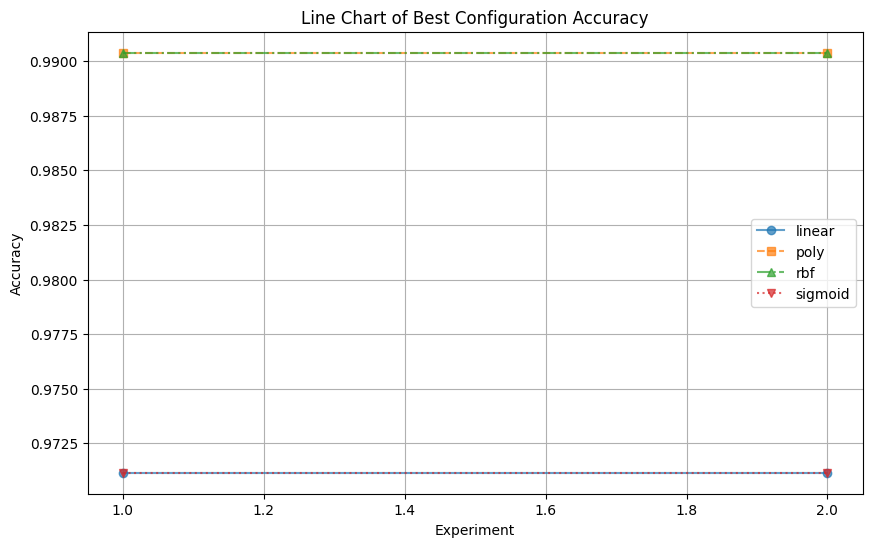

In [ ]:
import matplotlib.pyplot as plt
# Group data berdasarkan 'Experiment' dan 'Kernel' lalu hitung rata-rata akurasi
grouped_df = best_config_df.groupby(['Experiment', 'kernel'])['accuracy'].mean().reset_index()

# Definisikan linestyle dan marker
linestyles = ['-', '--', '-.', ':']
kernel_styles = {kernel: style for kernel, style in zip(grouped_df['kernel'].unique(), linestyles)}
markers = ['o', 's', '^', 'v']
kernel_markers = {kernel: marker for kernel, marker in zip(grouped_df['kernel'].unique(), markers)}


# Buat line chart
plt.figure(figsize=(10, 6))

for kernel in grouped_df['kernel'].unique():
    data = grouped_df[grouped_df['kernel'] == kernel]
    # Gunakan alpha, linestyle, dan marker untuk membedakan garis
    plt.plot(data['Experiment'], data['accuracy'],
             label=kernel, alpha=0.7,
             linestyle=kernel_styles[kernel],
             marker=kernel_markers[kernel])

plt.xlabel('Experiment')
plt.ylabel('Accuracy')
plt.title('Line Chart of Best Configuration Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Descriptive Statistics for Each Kernel
from IPython.display import display, HTML
# Group by 'kernel' and calculate descriptive statistics for 'accuracy' and 'selected_features'
kernel_descriptive_stats_acc = best_config_df.groupby('kernel')[['accuracy']].describe()
kernel_descriptive_stats_sf = best_config_df.groupby('kernel')[['selected_features']].describe()

# Display the DataFrame with scrollable output
display(HTML(kernel_descriptive_stats_acc.to_html(classes="table", max_rows=20, max_cols=10, border=0)))
display(HTML(kernel_descriptive_stats_sf.to_html(classes="table", max_rows=20, max_cols=10, border=0)))

## Implementasi Fitur Seleksi Terbaik Tiap Kernel ke Kernel Lain

In [ ]:
# Group by 'Kernel' and find the maximum accuracy for each kernel
best_accuracy_per_kernel = best_config_df.loc[best_config_df.groupby('kernel')['accuracy'].idxmax()]

# Display the filtered DataFrame
print(best_accuracy_per_kernel[['Experiment', 'kernel', 'pop_size', 'p_cross', 'p_mut', 'generations', 'selected_features', 'feature_names', 'accuracy']])


   Experiment   kernel  pop_size  p_cross     p_mut  generations  \
0           1   linear        50      0.7  0.026250           19   
3           1     poly        40      0.7  0.001563            9   
1           1      rbf        40      0.6  0.001563           10   
2           1  sigmoid        40      0.7  0.051563           16   

   selected_features                                      feature_names  \
0               10.0  [Gender_Male, Polyuria_Yes, Polydipsia_Yes, Po...   
3                8.0  [Age, Gender_Male, Polyuria_Yes, Polydipsia_Ye...   
1               10.0  [Gender_Male, Polyuria_Yes, Polydipsia_Yes, we...   
2                9.0  [Gender_Male, Polyuria_Yes, Polydipsia_Yes, Ge...   

   accuracy  
0  0.971154  
3  0.990385  
1  0.990385  
2  0.971154  


In [ ]:
best_features_by_kernel_df = best_accuracy_per_kernel[['kernel', 'feature_names']]
best_features_by_kernel = best_features_by_kernel_df.set_index('kernel')['feature_names'].to_dict()

print(best_features_by_kernel_df)

    kernel                                      feature_names
0   linear  [Gender_Male, Polyuria_Yes, Polydipsia_Yes, Po...
3     poly  [Age, Gender_Male, Polyuria_Yes, Polydipsia_Ye...
1      rbf  [Gender_Male, Polyuria_Yes, Polydipsia_Yes, we...
2  sigmoid  [Gender_Male, Polyuria_Yes, Polydipsia_Yes, Ge...


In [ ]:
def evaluate_cross_kernel(features, test_kernel):
    X_train_best = X_train_scale_df[features]
    X_test_best = X_test_scale_df[features]
    # print("Kolom dari X_train_best:", X_train_best.columns.tolist())

    # Ambil parameter optimal untuk kernel, pilih nilai pertama jika terdapat daftar
    if test_kernel == 'linear':
        params = {'C': float(kernel_configs['linear']['C'])}  # Ambil nilai C optimal pertama sebagai float
    elif test_kernel == 'rbf':
        params = {'C': float(kernel_configs['rbf']['C']), 'gamma': float(kernel_configs['rbf']['gamma'])}
    elif test_kernel == 'sigmoid':
        params = {'C': float(kernel_configs['sigmoid']['C']), 'gamma': float(kernel_configs['sigmoid']['gamma'])}
    elif test_kernel == 'poly':
        params = {
            'C': float(kernel_configs['poly']['C']),
            'degree': int(kernel_configs['poly']['degree']),  # degree biasanya berupa integer
            'gamma': kernel_configs['poly']['gamma']  # gamma bisa 'scale' atau 'auto', jadi tidak perlu diubah
        }

    # Uji dengan kernel tertentu
    svm = SVC(kernel=test_kernel, **params)
    svm.fit(X_train_best, y_train)

    # Prediksi dan hitung akurasi untuk data pelatihan (train)
    y_train_pred = svm.predict(X_train_best)
    train_accuracy = accuracy_score(y_train, y_train_pred)

    # Prediksi dan hitung akurasi untuk data pengujian (test)
    y_test_pred = svm.predict(X_test_best)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    # y_pred = svm.predict(X_test_best)
    # accuracy = accuracy_score(y_test, y_pred)
    
    return train_accuracy, test_accuracy

# Evaluasi fitur terbaik setiap kernel pada kernel lainnya
cross_kernel_result_train = {}
cross_kernel_result_test = {}

for kernel_name, features in best_features_by_kernel.items():
    result_train = {}
    result_test = {}
    for test_kernel in kernel_configs.keys():
        train_accuracy, test_accuracy = evaluate_cross_kernel(features, test_kernel)
        result_train[test_kernel] = train_accuracy
        result_test[test_kernel] = test_accuracy
    
    cross_kernel_result_train[kernel_name] = result_train
    cross_kernel_result_test[kernel_name] = result_test

# Convert to DataFrame for better readability
train_accuracy_df = pd.DataFrame(cross_kernel_result_train)
test_accuracy_df = pd.DataFrame(cross_kernel_result_test)

# Tampilkan hasil
print("Akurasi Pelatihan (Train Accuracy):\n", train_accuracy_df)
print("\nAkurasi Pengujian (Test Accuracy):\n", test_accuracy_df)

Akurasi Pelatihan (Train Accuracy):
            linear      poly       rbf   sigmoid
linear   0.930288  0.920673  0.925481  0.913462
rbf      0.983173  0.975962  0.990385  0.978365
sigmoid  0.920673  0.889423  0.920673  0.923077
poly     0.983173  0.975962  0.990385  0.978365

Akurasi Pengujian (Test Accuracy):
            linear      poly       rbf   sigmoid
linear   0.971154  0.913462  0.942308  0.942308
rbf      0.942308  0.990385  0.990385  0.971154
sigmoid  0.961538  0.894231  0.942308  0.971154
poly     0.951923  0.990385  0.961538  0.980769


## Uji Signifikansi

In [ ]:
# print summary_Df bagian kolom kernel dan beyst accuracy
best_accuracy_per_kernel_ujistat = best_accuracy_per_kernel[['Kernel', 'accuracy']]
results_df_ujistat = results_df[['Kernel', 'Accuracy']]
#Gabungkan dua dataframe tersebut
ujistat_df = pd.merge(results_df_ujistat, best_accuracy_per_kernel_ujistat,  on='Kernel')

# rename kolom accuracy dengan "Akurasi Sebelum GA" dan "Test Accuracy" dengan "Akurasi Setelah GA"
ujistat_df = ujistat_df.rename(columns={'Accuracy': 'Akurasi Sebelum GA'})
ujistat_df = ujistat_df.rename(columns={'accuracy': 'Akurasi Setelah GA'})
print(ujistat_df)

    Kernel  Akurasi Sebelum GA  Akurasi Setelah GA
0   linear            0.932692            0.971154
1      rbf            0.980769            0.990385
2  sigmoid            0.913462            0.971154
3     poly            0.961538            0.990385


In [ ]:
import numpy as np
from scipy.stats import shapiro, ttest_rel, wilcoxon

# Uji normalitas pada selisih data berpasangan
differences = ujistat_df['Akurasi Setelah GA'] - ujistat_df['Akurasi Sebelum GA']
stat_diff, p_value_diff = shapiro(differences)

print("Uji Normalitas untuk Selisih Data Berpasangan:", "P-Value =", p_value_diff)

# Periksa apakah selisih data berpasangan berdistribusi normal
alpha = 0.05  # Tingkat signifikansi

if p_value_diff > alpha:
    print("Data selisih berdistribusi normal. Lanjutkan dengan paired t-test satu arah.")
    # Melakukan paired t-test satu arah
    t_stat, p_ttest = ttest_rel(ujistat_df['Akurasi Sebelum GA'], ujistat_df['Akurasi Setelah GA'], alternative='less')
    print("Hasil paired t-test satu arah:", "T-Statistic =", t_stat, "P-Value =", p_ttest)
else:
    print("Data selisih tidak berdistribusi normal. Lanjutkan dengan Wilcoxon signed-rank test satu arah.")
    # Melakukan Wilcoxon signed-rank test satu arah
    w_stat, p_wilcoxon = wilcoxon(ujistat_df['Akurasi Sebelum GA'], ujistat_df['Akurasi Setelah GA'], alternative='less')
    print("Hasil Wilcoxon signed-rank test satu arah:", "W-Statistic =", w_stat, "P-Value =", p_wilcoxon)


Uji Normalitas untuk Selisih Data Berpasangan: P-Value = 0.9950640185005765
Data selisih berdistribusi normal. Lanjutkan dengan paired t-test satu arah.
Hasil paired t-test satu arah: T-Statistic = -3.3626912299068366 P-Value = 0.021823117520386716
